# Path Following Algorithms: Pure Pursuit and RAMSETE

After generating a smooth path for a robot to follow (as shown in previous notebooks), the next challenge is to design a controller that enables the robot to accurately track that path on the field. This process is known as **path following**.

In competitive robotics (such as VEX and FRC), two of the most widely used path following algorithms are:

- **Pure Pursuit**: A geometric, lookahead-based algorithm that is simple to implement and works well for many mobile robots.
- **RAMSETE**: A more advanced, nonlinear feedback controller that provides robust tracking even at high speeds and with aggressive maneuvers.

This notebook introduces both approaches, demonstrates their implementation, and compares their performance on the same example path.

## Pure Pursuit Algorithm: Implementation and Example

The Pure Pursuit algorithm is a geometric path following method that uses a lookahead point on the path to compute steering commands. At each control step, the robot "pursues" a point a fixed distance ahead of its current position, adjusting its heading to minimize the distance to this lookahead point.

**Key features:**
- Simple to implement and tune
- Works well for smooth, continuous paths
- May struggle with sharp turns or high-speed tracking

Let's implement Pure Pursuit and demonstrate it on a simple path.

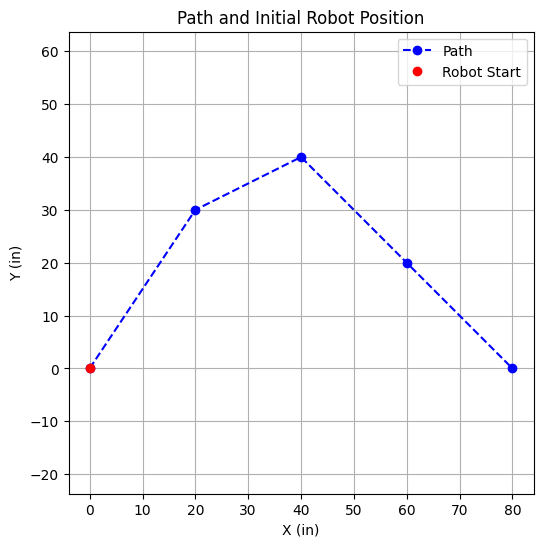

In [5]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Define a simple path (e.g., a set of waypoints)
path = np.array([
    [0, 0],
    [20, 30],
    [40, 40],
    [60, 20],
    [80, 0]
])

# Robot model: differential drive, initial state
robot_state = {
    'x': 0.0,
    'y': 0.0,
    'theta': 0.0  # heading in radians
}

# Plot the path and initial robot position
plt.figure(figsize=(6,6))
plt.plot(path[:,0], path[:,1], 'b--o', label='Path')
plt.plot(robot_state['x'], robot_state['y'], 'ro', label='Robot Start')
plt.xlabel('X (in)')
plt.ylabel('Y (in)')
plt.title('Path and Initial Robot Position')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

### How Pure Pursuit Works

At each control step, the Pure Pursuit algorithm:
1. Finds a lookahead point on the path a fixed distance ahead of the robot.
2. Computes the curvature required to reach that point from the robot's current position.
3. Converts the curvature into left/right wheel velocities (for a differential drive robot).

**Parameters:**
- Lookahead distance: How far ahead on the path to "chase" (affects smoothness and responsiveness)
- Path: The sequence of points the robot should follow

Let's implement the core logic for Pure Pursuit.

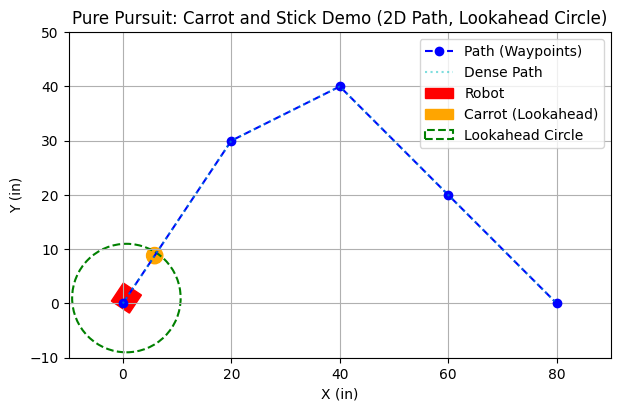

In [6]:
# Demonstration: Carrot and Stick (Pure Pursuit Intuition on 2D Path, with Lookahead Circle)
import matplotlib.patches as patches
from matplotlib import animation

# Use the original 2D path and interpolate for smoothness
carrot_path = path  # use the main path defined earlier

def interpolate_path_dense(path, num_points):
    dists = np.linalg.norm(np.diff(path, axis=0), axis=1)
    arc = np.concatenate(([0], np.cumsum(dists)))
    total = arc[-1]
    s_vals = np.linspace(0, total, num_points)
    ref_points = []
    for s in s_vals:
        for i in range(len(arc)-1):
            if arc[i] <= s <= arc[i+1]:
                ratio = (s - arc[i]) / (arc[i+1] - arc[i]) if arc[i+1] > arc[i] else 0
                pt = path[i] + ratio * (path[i+1] - path[i])
                ref_points.append(pt)
                break
    return np.array(ref_points)

dense_carrot_path = interpolate_path_dense(carrot_path, 200)

# Robot starts at the beginning of the path, heading along the first segment
carrot_robot = {'x': dense_carrot_path[0,0], 'y': dense_carrot_path[0,1],
                'theta': np.arctan2(dense_carrot_path[1,1] - dense_carrot_path[0,1],
                                   dense_carrot_path[1,0] - dense_carrot_path[0,0])}
lookahead_dist = 10.0
robot_size = 4.0  # side length of the robot square

# Find intersection of lookahead circle and path
from numpy.linalg import norm

def find_lookahead_intersection(path, x, y, lookahead):
    # Returns the first intersection point of the lookahead circle and the path
    for i in range(len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        d = p2 - p1
        f = p1 - np.array([x, y])
        a = np.dot(d, d)
        b = 2 * np.dot(f, d)
        c = np.dot(f, f) - lookahead**2
        disc = b**2 - 4*a*c
        if disc < 0:
            continue  # no intersection
        sqrt_disc = np.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)
        for t in [t1, t2]:
            if 0 <= t <= 1:
                intersect = p1 + t * d
                # Only return the first intersection ahead of the robot
                dx = intersect[0] - x
                dy = intersect[1] - y
                heading_to_point = np.arctan2(dy, dx)
                angle_diff = np.arctan2(np.sin(heading_to_point - carrot_robot['theta']), np.cos(heading_to_point - carrot_robot['theta']))
                if np.abs(angle_diff) < np.pi/2 + 0.2:  # allow a bit more than 90 deg
                    return intersect
    # If no intersection, return last path point
    return path[-1]

# Prepare for animation
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(carrot_path[:,0], carrot_path[:,1], 'b--o', label='Path (Waypoints)')
ax.plot(dense_carrot_path[:,0], dense_carrot_path[:,1], 'c:', alpha=0.5, label='Dense Path')
ax.set_xlim(np.min(carrot_path[:,0])-10, np.max(carrot_path[:,0])+10)
ax.set_ylim(np.min(carrot_path[:,1])-10, np.max(carrot_path[:,1])+10)
ax.set_xlabel('X (in)')
ax.set_ylabel('Y (in)')
ax.set_title('Pure Pursuit: Carrot and Stick Demo (2D Path, Lookahead Circle)')
ax.grid(True)
ax.set_aspect('equal')  # Ensure circles are round

# Robot as a square (Polygon)
robot_square = patches.Polygon([[0,0],[0,0],[0,0],[0,0]], closed=True, color='red', label='Robot')
carrot_patch = patches.Circle((0,0), 1.5, color='orange', label='Carrot (Lookahead)')
lookahead_circle = patches.Circle((carrot_robot['x'], carrot_robot['y']), lookahead_dist, fill=False, color='green', linestyle='--', linewidth=1.5, label='Lookahead Circle')
ax.add_patch(robot_square)
ax.add_patch(carrot_patch)
ax.add_patch(lookahead_circle)
ax.legend()

# Animation update function
def update(frame):
    global carrot_robot
    # Find carrot at intersection
    carrot = find_lookahead_intersection(dense_carrot_path, carrot_robot['x'], carrot_robot['y'], lookahead_dist)
    dx = carrot[0] - carrot_robot['x']
    dy = carrot[1] - carrot_robot['y']
    target_angle = np.arctan2(dy, dx)
    angle_error = target_angle - carrot_robot['theta']
    angle_error = np.arctan2(np.sin(angle_error), np.cos(angle_error))
    omega = 1.0 * angle_error
    v = 4.0
    carrot_robot['x'] += v * np.cos(carrot_robot['theta']) * 0.15
    carrot_robot['y'] += v * np.sin(carrot_robot['theta']) * 0.15
    carrot_robot['theta'] += omega * 0.15
    # Update robot square
    cx, cy, th = carrot_robot['x'], carrot_robot['y'], carrot_robot['theta']
    half = robot_size/2
    corners = np.array([[-half, -half], [half, -half], [half, half], [-half, half]])
    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    world_corners = (corners @ rot.T) + np.array([cx, cy])
    robot_square.set_xy(world_corners)
    # Update carrot and lookahead circle
    carrot_patch.center = (carrot[0], carrot[1])
    lookahead_circle.center = (cx, cy)
    return robot_square, carrot_patch, lookahead_circle

# Reset robot for animation
def reset_robot():
    carrot_robot['x'] = dense_carrot_path[0,0]
    carrot_robot['y'] = dense_carrot_path[0,1]
    carrot_robot['theta'] = np.arctan2(dense_carrot_path[1,1] - dense_carrot_path[0,1],
                                       dense_carrot_path[1,0] - dense_carrot_path[0,0])

reset_robot()
ani = animation.FuncAnimation(fig, update, frames=40, interval=300, blit=True, repeat=False)
plt.show()

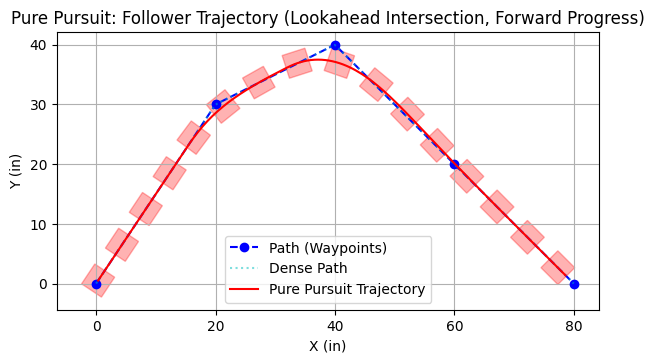

In [7]:
# Pure Pursuit: Simulated Follower Trajectory (with Lookahead Intersection, Forward Progress)
import matplotlib.patches as patches

# Use the same dense path and lookahead intersection logic as the demo
robot_traj = []
robot_theta = []
robot_state = {'x': dense_carrot_path[0,0], 'y': dense_carrot_path[0,1],
               'theta': np.arctan2(dense_carrot_path[1,1] - dense_carrot_path[0,1],
                                  dense_carrot_path[1,0] - dense_carrot_path[0,0])}
lookahead_dist = 10.0
robot_size = 4.0

# Helper: forward-progressing lookahead intersection
last_seg_idx = 0
def find_lookahead_intersection_forward(path, x, y, lookahead, last_idx):
    for i in range(last_idx, len(path)-1):
        p1 = path[i]
        p2 = path[i+1]
        d = p2 - p1
        f = p1 - np.array([x, y])
        a = np.dot(d, d)
        b = 2 * np.dot(f, d)
        c = np.dot(f, f) - lookahead**2
        disc = b**2 - 4*a*c
        if disc < 0:
            continue
        sqrt_disc = np.sqrt(disc)
        t1 = (-b + sqrt_disc) / (2*a)
        t2 = (-b - sqrt_disc) / (2*a)
        for t in [t1, t2]:
            if 0 <= t <= 1:
                intersect = p1 + t * d
                dx = intersect[0] - x
                dy = intersect[1] - y
                heading_to_point = np.arctan2(dy, dx)
                angle_diff = np.arctan2(np.sin(heading_to_point - robot_state['theta']), np.cos(heading_to_point - robot_state['theta']))
                if np.abs(angle_diff) < np.pi/2 + 0.2:
                    return intersect, i
    return path[-1], len(path)-2

for step in range(200):
    carrot, last_seg_idx = find_lookahead_intersection_forward(dense_carrot_path, robot_state['x'], robot_state['y'], lookahead_dist, last_seg_idx)
    dx = carrot[0] - robot_state['x']
    dy = carrot[1] - robot_state['y']
    target_angle = np.arctan2(dy, dx)
    angle_error = target_angle - robot_state['theta']
    angle_error = np.arctan2(np.sin(angle_error), np.cos(angle_error))
    omega = 1.0 * angle_error
    v = 4.0
    robot_state['x'] += v * np.cos(robot_state['theta']) * 0.15
    robot_state['y'] += v * np.sin(robot_state['theta']) * 0.15
    robot_state['theta'] += omega * 0.15
    robot_traj.append([robot_state['x'], robot_state['y']])
    robot_theta.append(robot_state['theta'])
    if np.linalg.norm([robot_state['x'] - dense_carrot_path[-1,0], robot_state['y'] - dense_carrot_path[-1,1]]) < 2.0:
        break
robot_traj = np.array(robot_traj)
robot_theta = np.array(robot_theta)

# Plot the result
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(carrot_path[:,0], carrot_path[:,1], 'b--o', label='Path (Waypoints)')
ax.plot(dense_carrot_path[:,0], dense_carrot_path[:,1], 'c:', alpha=0.5, label='Dense Path')
ax.plot(robot_traj[:,0], robot_traj[:,1], 'r-', label='Pure Pursuit Trajectory')

# Draw robot squares along the trajectory
for i in range(0, len(robot_traj), max(1, len(robot_traj)//15)):
    cx, cy, th = robot_traj[i,0], robot_traj[i,1], robot_theta[i]
    half = robot_size/2
    corners = np.array([[-half, -half], [half, -half], [half, half], [-half, half]])
    rot = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])
    world_corners = (corners @ rot.T) + np.array([cx, cy])
    robot_patch = patches.Polygon(world_corners, closed=True, color='red', alpha=0.3)
    ax.add_patch(robot_patch)

ax.set_xlabel('X (in)')
ax.set_ylabel('Y (in)')
ax.set_title('Pure Pursuit: Follower Trajectory (Lookahead Intersection, Forward Progress)')
ax.grid(True)
ax.set_aspect('equal')
ax.legend()
plt.show()

### Limitations and Shortcomings of Pure Pursuit

While Pure Pursuit is simple and effective for many smooth, non-intersecting paths, it has several important limitations:

- **Path Crossings and Loops:**
  - If the path crosses itself (forms a loop or figure-8), the lookahead circle may intersect the path at multiple points. Pure Pursuit typically selects the first intersection ahead, which can cause the robot to jump to the wrong branch or "cut across" the loop, leading to unpredictable or incorrect behavior.
  - This makes Pure Pursuit unreliable for complex paths with self-intersections or sharp reversals.

- **Sharp Turns and Discontinuities:**
  - Pure Pursuit assumes the robot can instantly steer toward the lookahead point. On sharp corners, the robot may cut the corner or overshoot, especially if the lookahead distance is large.
  - Reducing the lookahead distance improves cornering but can make the robot oscillate or become unstable.

- **No Explicit Progress Tracking:**
  - Pure Pursuit does not explicitly track progress along the path. If the robot gets off the path (e.g., due to wheel slip or a disturbance), it may "shortcut" to a later part of the path, missing intermediate waypoints.

- **No Speed or Dynamics Awareness:**
  - The algorithm does not account for the robot's speed, acceleration limits, or turning radius. It may command turns that are physically impossible for the robot to follow at high speed.

- **No Feedback on Path Error:**
  - Pure Pursuit only reacts to the current lookahead point, not the overall error from the path. This can lead to steady-state tracking errors, especially on curves.

**Summary:**
- Pure Pursuit is best for smooth, non-intersecting paths and moderate speeds.
- For complex paths, high-speed maneuvers, or when precise path tracking is required, more advanced controllers (like RAMSETE or MPC) are preferred.

## RAMSETE Controller: Implementation and Example

The RAMSETE (Rapid Motorized Steering and Trajectory Error) controller is a nonlinear feedback controller designed for robust path tracking, even at high speeds and with aggressive maneuvers. It is widely used in FRC and advanced VEX projects.

**Key features:**
- Uses a nonlinear control law to minimize both position and heading error
- Provides smooth, accurate tracking even with disturbances
- Requires a model of the robot's kinematics

Let's implement a basic RAMSETE controller and demonstrate it on the same path.

### How RAMSETE Works

The RAMSETE controller computes control commands based on the robot's current pose and the desired pose on the path. It uses a nonlinear feedback law to drive both the position and heading errors to zero.

**Parameters:**
- $b$ (aggressiveness): Higher values make the controller more aggressive
- $\zeta$ (damping): Controls how quickly errors are corrected

The RAMSETE controller requires a reference trajectory with position, heading, and velocity at each point. We'll use the same path as before, with a constant reference velocity.

### Pros and Cons of RAMSETE
**Pros:**
- Robust to disturbances and model errors; can recover from being off-path or misaligned.
- Tracks both position and heading errors, leading to precise path following even on aggressive or curved trajectories.
- Handles high-speed maneuvers and sharp turns better than geometric-only controllers like Pure Pursuit.
- Provides smooth, continuous control commands suitable for real robots.
- Widely used in advanced robotics competitions (FRC, VEXU, etc.).

**Cons:**
- Requires a model of the robot's kinematics and a precomputed reference trajectory (with position, heading, and velocity at each point).
- More complex to implement and tune than Pure Pursuit; involves nonlinear feedback and gain parameters ($b$, $\zeta$).
- Sensitive to errors in the reference trajectory or robot model (e.g., wheel slip, incorrect velocity estimates).
- May require additional feedforward or velocity control for best performance on real hardware.


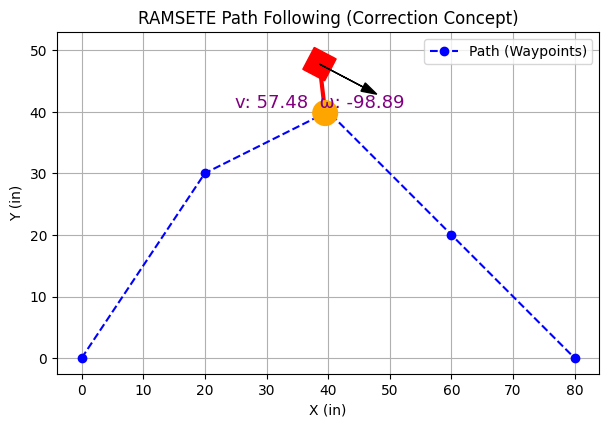

In [8]:
# RAMSETE controller core logic (improved visualization)
def ramsete_control(x, y, theta, x_ref, y_ref, theta_ref, v_ref, b=2.0, zeta=0.7):
    # Compute pose error in robot frame
    dx = x_ref - x
    dy = y_ref - y
    e_x = np.cos(theta) * dx + np.sin(theta) * dy
    e_y = -np.sin(theta) * dx + np.cos(theta) * dy
    e_theta = theta_ref - theta
    e_theta = np.arctan2(np.sin(e_theta), np.cos(e_theta))
    # RAMSETE gain
    k = 2 * zeta * np.sqrt(v_ref**2 + b * e_theta**2)
    # Control law
    v = v_ref * np.cos(e_theta) + k * e_x
    omega = b * v_ref * e_y + k * e_theta
    return v, omega

def interpolate_path(path, num_points):
    dists = np.linalg.norm(np.diff(path, axis=0), axis=1)
    arc = np.concatenate(([0], np.cumsum(dists)))
    total = arc[-1]
    s_vals = np.linspace(0, total, num_points)
    ref_points = []
    for s in s_vals:
        for i in range(len(arc)-1):
            if arc[i] <= s <= arc[i+1]:
                ratio = (s - arc[i]) / (arc[i+1] - arc[i]) if arc[i+1] > arc[i] else 0
                pt = path[i] + ratio * (path[i+1] - path[i])
                ref_points.append(pt)
                break
    return np.array(ref_points)

def compute_headings(points):
    headings = []
    for i in range(len(points)-1):
        dx = points[i+1,0] - points[i,0]
        dy = points[i+1,1] - points[i,1]
        headings.append(np.arctan2(dy, dx))
    headings.append(headings[-1])
    return np.array(headings)

num_steps = 150
traj_points = interpolate_path(path, num_steps)
traj_headings = compute_headings(traj_points)
traj_v = np.full(num_steps, 8.0)

# --- Focused Correction Illustration Only ---
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(path[:,0], path[:,1], 'b--o', label='Path (Waypoints)')

# Pick a reference point mid-path
ref_idx = int(len(traj_points) * 0.5)
ref_x, ref_y = traj_points[ref_idx]
ref_theta = traj_headings[ref_idx]
v_ref = traj_v[ref_idx]

# Place the robot moderately off the path (e.g., 8 units perpendicular to heading)
offset = 8.0
off_x = ref_x - offset * np.sin(ref_theta)
off_y = ref_y + offset * np.cos(ref_theta)
off_theta = ref_theta - 0.6  # moderate heading error

# Compute RAMSETE control output for this instant
v_cmd, omega_cmd = ramsete_control(off_x, off_y, off_theta, ref_x, ref_y, ref_theta, v_ref)

# Draw reference point (orange dot)
ref_patch = patches.Circle((ref_x, ref_y), 2.0, color='orange', zorder=3)
ax.add_patch(ref_patch)

# Draw robot (off path) as a red square
robot_size = 4.0
half = robot_size/2
corners = np.array([[-half, -half], [half, -half], [half, half], [-half, half]])
rot = np.array([[np.cos(off_theta), -np.sin(off_theta)], [np.sin(off_theta), np.cos(off_theta)]])
world_corners = (corners @ rot.T) + np.array([off_x, off_y])
robot_patch = patches.Polygon(world_corners, closed=True, color='red', zorder=4)
ax.add_patch(robot_patch)

# Draw robot heading arrow (black)
arrow_len = 8.0
arrow_dx = arrow_len * np.cos(off_theta)
arrow_dy = arrow_len * np.sin(off_theta)
ax.arrow(off_x, off_y, arrow_dx, arrow_dy, head_width=1.5, head_length=2.5, fc='black', ec='black', zorder=5)

# Draw error vector (robot to reference)
ax.plot([off_x, ref_x], [off_y, ref_y], 'r-', linewidth=3, zorder=2)

# Optionally, show the commanded velocity and angular velocity as text
ax.text(off_x, off_y-7, f"v: {v_cmd:.2f}  ω: {omega_cmd:.2f}", fontsize=13, color='purple', ha='center', zorder=6)

ax.set_xlabel('X (in)')
ax.set_ylabel('Y (in)')
ax.set_title('RAMSETE Path Following (Correction Concept)')
ax.grid(True)
ax.set_aspect('equal')
ax.legend()
plt.show()

### RAMSETE Correction Concept: Visual Explanation
- <span style="color:orange; font-weight:bold;">Orange dot</span>: The reference point on the path that the robot is trying to reach and align with.
- <span style="color:black; font-weight:bold;">Black arrow</span>: The robot's current heading (direction it is facing).
- <span style="color:red; font-weight:bold;">Red square</span>: The robot's current (off-path) position and orientation.
- <span style="color:red; font-weight:bold;">Red line</span>: The error vector from the robot to the reference point.
<br>
This diagram shows how the RAMSETE controller computes a correction when the robot is off the path and misaligned. The controller generates commands to drive the robot back to the path and align its heading with the reference.

## Pure Pursuit vs. RAMSETE: Final Comparison
| Feature                | Pure Pursuit                        | RAMSETE                                 |
|------------------------|-------------------------------------|------------------------------------------|
| **Type**               | Geometric, lookahead-based          | Nonlinear feedback, model-based          |
| **Path Tracking**      | Good for smooth, simple paths       | Excellent, even for aggressive paths     |
| **Handles Loops/Turns**| Struggles with sharp turns/loops    | Handles sharp turns and loops well       |
| **Error Correction**   | Only reacts to lookahead point      | Minimizes both position and heading error|
| **Speed Awareness**    | No                                 | Yes (uses reference velocity)            |
| **Implementation**     | Simple, easy to tune                | More complex, needs trajectory & tuning  |
| **Robustness**         | Can fail if off path or on loops    | Recovers from off-path, robust           |
| **Use Cases**          | Educational, simple robots/paths    | Advanced robots, competition, precision  |

**Summary:**
- Use **Pure Pursuit** for simple, smooth paths and when ease of implementation is a priority.
- Use **RAMSETE** for high-speed, aggressive, or complex paths where precise tracking and robustness are required.
- RAMSETE is preferred in advanced robotics competitions and for real-world applications where disturbances and model errors are common.